In [1413]:
import os
import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, make_regression
from sklearn.model_selection import train_test_split
housing = fetch_california_housing()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, test_size=0.98, random_state=2)
XR, yR = make_regression(n_samples=555, n_features=1, noise=10, random_state=5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(XR, yR, test_size=0.20, random_state=2)

def normalize_dataset(X):
    return tf.keras.utils.normalize(X)



(444, 1) * (1, 444) + (1,) = (444, 444)
(444, 1) * (1, 444) + (1,) = (444, 444)
(444, 444) * (444, 444) + (1,) = (444, 444)
(444, 444) * (444, 444) + (1,) = (444, 444)
(444, 444) * (444, 444) + (1,) = (444, 444)
(444, 444) * (444, 444) + (1,) = (444, 444)
(444, 444) * (444, 444) + (1,) = (444, 444)
(444, 444) * (444, 444) + (1,) = (444, 444)
(444, 444) * (444, 444) + (1,) = (444, 444)
(444, 444) * (444, 444) + (1,) = (444, 444)
tf.Tensor(
[-14.00571155   2.8505944  -21.13887112  41.78918172  39.688009
 -13.60057933 -11.58036183  37.3086116   33.0749249  -37.10460008
   9.76869851  -8.98222864 -40.16018087  18.18329167  13.17365018
  25.32572085  91.07185723  15.15427353  -6.20236298  38.56503127
  16.98240825  30.39331955  15.72669827 -13.09647547  14.32776692
  34.50679995   3.06307658  20.33764864  19.71301239  35.82922944
 -41.94545752 -41.74319393 -48.12134227 -16.45642614  14.00028413
  14.81612514 -13.23416797  44.1254902   46.72994906 -12.47750669
  50.30385023   7.78544112   0.

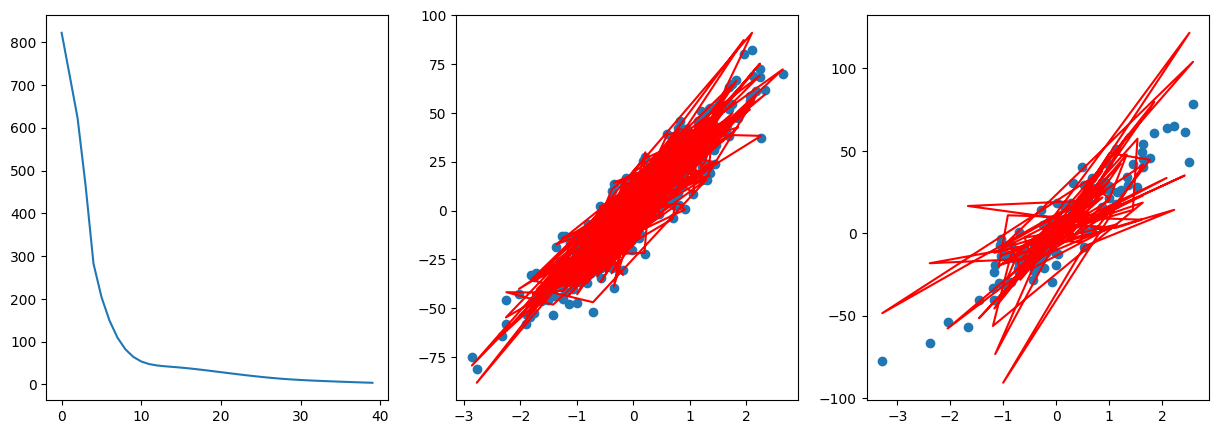

In [1498]:
class Layer(tf.Module):
    def __init__(self, activation=tf.identity):
        self.activation = activation
        self.build = False
        self.normalized = False

    @tf.function(reduce_retracing=True)
    def xavier_init(self, shape):
        in_dim, out_dim = shape
        xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
        weight_vals = tf.cast(tf.random.uniform(shape=(in_dim, out_dim), 
                                        minval=-xavier_lim, maxval=xavier_lim, seed=22, dtype=tf.float32), dtype=tf.double)
        return weight_vals

    @tf.function
    def __call__(self, X):
        if not self.build:
            n_samples, n_features = X.shape
            self.weights = tf.Variable(self.xavier_init(shape=(n_features, n_samples)), name="Weights", dtype=tf.double, trainable=True )
            self.bias = tf.Variable(tf.zeros(shape=1, dtype=tf.double), name="Bias", dtype=tf.double, trainable=True )
            self.build = True

        z = tf.add(tf.matmul(X, self.weights), self.bias)

        print(X.shape,"*",self.weights.shape,"+",self.bias.shape, "=", z.shape)
        return self.activation(z)

    

class MLPLinearRegressor(tf.Module):
    def __init__(self, layers, X, X_test, y, y_test, lr=0.001, epochs=10):
        self.layers = layers
        self.lr = lr
        self.epochs = epochs
        self.loaded = False
        self.X = X 
        self.XN = normalize_dataset(X)
        self.XN_test = normalize_dataset(X_test)
        self.y = y
        self.y_test = y_test
        self.X_test = X_test
        self.learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=1000000, decay_rate=0.96, staircase=True)
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.train_mse = tf.keras.metrics.MeanSquaredError()
        self.train_accuracy = tf.keras.metrics.MeanSquaredLogarithmicError()
        self.train_precision = tf.keras.metrics.Precision()
        self.test_mse = tf.keras.metrics.MeanSquaredError()
        self.test_accuracy = tf.keras.metrics.MeanSquaredLogarithmicError()
        self.test_precision = tf.keras.metrics.Precision()
        self.regularizer = tf.keras.regularizers.L1
        self.loss_history = [e for e in range(epochs)]

    @tf.function(reduce_retracing=True)
    def train_accuracy_rrsse(self, predicted):
        return tf.divide(tf.sqrt(
            tf.divide(
                tf.reduce_sum(tf.square(tf.abs((tf.subtract(predicted, self.y))))),
                tf.reduce_sum(tf.square(tf.abs((tf.subtract(tf.reduce_mean(self.y), predicted)))))
            )), predicted.shape[0]
        )

    @tf.function(reduce_retracing=True)
    def loss(self, predicted):
        return tf.losses.mean_squared_error(self.y, predicted)

    @tf.function(reduce_retracing=True)
    def calc_metrics(self):
        self.train_accuracy.update_state(self.y, self.predicted)
        self.train_precision.update_state(self.y, self.predicted)
        self.train_mse.update_state(self.y, self.predicted)
        #self.test_accuracy.update_state(self.y_test, self.predicted_test)
        #self.test_precision.update_state(self.y_test, self.predicted_test)
        #self.test_mse.update_state(self.y_test, self.predicted_test)

    @tf.function(reduce_retracing=True)
    def train_step(self, X):
        for layer in self.layers:
            X = layer(X)
        return X

    def train(self):
        self.weights = model.train_step(self.XN)
        self.vars = [self.layers[0].weights, self.layers[1].weights, self.layers[2].weights,self.layers[3].weights,self.layers[4].weights, self.layers[0].bias, self.layers[1].bias, self.layers[2].bias,self.layers[3].bias,self.layers[4].bias]

        for e in range(self.epochs):
            with tf.GradientTape(watch_accessed_variables=True, persistent=True) as tape:
                self.weights = self.train_step(self.XN)
                bias = self.layers[len(self.layers)-1].bias
                self.flatten_weights = tf.reduce_mean(self.weights, axis=0)
                self.predicted = self._predict(self.XN, self.flatten_weights)
                #self.predicted = self.predict(self.XN)
                #self.predicted_matrix = tf.subtract(tf.multiply(tf.transpose(self.XN), tf.reduce_mean(self.weights, axis=0)), self.layers[len(self.layers)-1].bias)
                #self.predicted = tf.reduce_sum(tf.subtract(tf.multiply(self.X, tf.reduce_sum(self.predicted_matrix, axis=1)), self.layers[len(self.layers)-1].bias), axis=1)
                
                loss = self.loss(self.predicted)
                self.loss_history[e] = loss.numpy()

            grads = tape.gradient(loss, self.vars)
            self.optimizer.apply_gradients(zip(grads, self.vars)) 

    def _predict(self, X, weights):
        return tf.reduce_mean(tf.add(self.layers[len(self.layers)-1].bias, tf.multiply(tf.transpose(X), weights)), axis=0)

    def predict(self, X):
        #come scegliere i migliori pesi?
        self.predicted_test = self._predict(X, [ self.flatten_weights[i] for i in range(self.X_test.shape[0]) ])


model = MLPLinearRegressor([
    Layer(),
    Layer(),
    Layer(),
    Layer(activation=tf.sigmoid),
    Layer()
], X_train2, X_test2, tf.squeeze(y_train2), tf.squeeze(y_test2), lr=0.01, epochs=40)


model.train()
model.predict(X_test2)
model.calc_metrics()


print("Train_MeanSquaredError: ", model.train_mse.result().numpy())
print("Train_Keras Accuracy: ", model.train_accuracy.result().numpy())
print("Train_Keras Precision: ", model.train_precision.result().numpy())
print('--------------------------------------------------------')
"""print("Test_MeanSquaredError: ", model.test_mse.result().numpy())
print("Test_Keras Accuracy: ", model.test_accuracy.result().numpy())
print("Test_Keras Precision: ", model.test_precision.result().numpy())"""

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot([e for e in range(model.epochs)], model.loss_history)

ax[1].scatter(X_train2[:, 0], y_train2[:])
ax[1].plot(X_train2[:, 0], model.predicted[:], color='r')

ax[2].scatter(X_test2[:, 0], y_test2[:])
ax[2].plot(X_test2[:, 0], model.predicted_test[:], color='r')

plt.show()

